In [ ]:
import tensorflow as tf


In [ ]:
model = tf.keras.models.load_model('/content/sample_data/cats_vs_dogs.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
classes = ['Cat','Dog']
def display_pred(image_path):
  plt.imshow(plt.imread(image_path))
  x = tf.keras.preprocessing.image.load_img(image_path,
                                            target_size=(128,128)) #For loading images from image_path with 128x128 dim
  x = tf.keras.preprocessing.image.img_to_array(x)  #image->numpy array
  x = tf.keras.applications.mobilenet_v2.preprocess_input(x) #For Normalization
  x = np.expand_dims(x,axis = 0)
  pred = model.predict(x)[0]
  plt.title('pred: {}'.format(classes[int(pred>0.5)]))

  plt.show()
  print(pred)

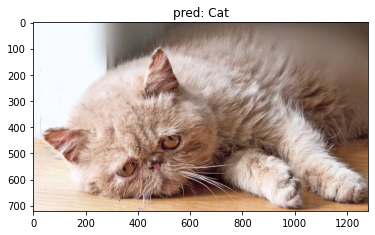

[0.0041877]


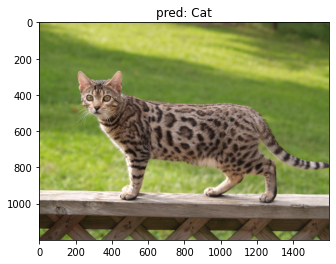

[0.00043297]


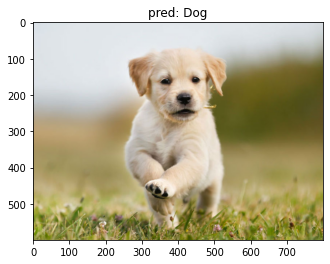

[0.9987244]


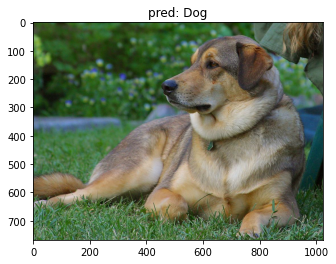

[0.99289525]


In [ ]:
#Testing my model
images = ['cat1','cat2','dog1','dog2']

main_path = '/content/sample_data/images/'

for i in images:
  display_pred(main_path + '{}.jpg'.format(i))

In [ ]:
#Building Custom Prediction class 
#Has : predict(),fromPath()->loads model artifact
%%writefile prediction.py

import tensorflow as tf
import numpy as np
import os
import base64

MODEL_NAME = 'cats_vs_dogs.h5'
CLASS_NAMES = ['Cat','Dog']

class catsVsDogsPrediction:
  def __init__(self,model):
    self._model = model
  def _preprocess(self,instances,size=128): ##ith instance is coming in string
    num_examples = len(instances)
    x_batch = np.zeros((num_examples,size,size,3))
    for i in range(num_examples):
      x = np.array(bytearray(base64.b64decode(instances[i])))
      x = np.reshape(x,(size,size,3))
      x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
      x_batch[i] = x
    return x_batch
  def _postprocess(self,preds):
    results = []
    for i,pred in enumerate(preds):
      p = np.squeeze(pred) #Removes any extra dimension
      results.append({
          'index': i,
          'Class_Name': CLASS_NAMES[int(p>0.5)],
          'raw_predict_value':'{:.4f}'.format(p)
      })
    return results

  def predict(self,instances,**kwargs):
    ##Preprocess->predict->postprocess
    if 'size' in kwargs:            #Preprocess
      size = int(kwargs.get('size'))
    else:
      size = 128
    x_batch = self._preprocess(instances,size)
    #prediction
    preds = self._model.predict(x_batch)
    #PostProcess
    results = self._postprocess(preds)
    return results
  @classmethod
  def from_path(cls,model_dir):
    model = tf.keras.models.load_model(os.path.join(model_dir,MODEL_NAME))
    return cls(model)
  


Overwriting prediction.py


In [ ]:
%%writefile setup.py
#Setup Script
from setuptools import setup

setup(
    name = 'Pradyut_CatsvsDogs',
    version = '0.0.1',
    include_package_data = False,
    scripts = ['prediction.py']
)

Overwriting setup.py


In [ ]:
#Creating our own bundle
!python3 setup.py sdist --formats=gztar

running sdist
running egg_info
creating Pradyut_CatsvsDogs.egg-info
writing Pradyut_CatsvsDogs.egg-info/PKG-INFO
writing dependency_links to Pradyut_CatsvsDogs.egg-info/dependency_links.txt
writing top-level names to Pradyut_CatsvsDogs.egg-info/top_level.txt
writing manifest file 'Pradyut_CatsvsDogs.egg-info/SOURCES.txt'
reading manifest file 'Pradyut_CatsvsDogs.egg-info/SOURCES.txt'
writing manifest file 'Pradyut_CatsvsDogs.egg-info/SOURCES.txt'

running check


creating Pradyut_CatsvsDogs-0.0.1
creating Pradyut_CatsvsDogs-0.0.1/Pradyut_CatsvsDogs.egg-info
copying files to Pradyut_CatsvsDogs-0.0.1...
copying prediction.py -> Pradyut_CatsvsDogs-0.0.1
copying setup.py -> Pradyut_CatsvsDogs-0.0.1
copying Pradyut_CatsvsDogs.egg-info/PKG-INFO -> Pradyut_CatsvsDogs-0.0.1/Pradyut_CatsvsDogs.egg-info
copying Pradyut_CatsvsDogs.egg-info/SOURCES.txt -> Pradyut_CatsvsDogs-0.0.1/Pradyut_CatsvsDogs.egg-info
copying Pradyut_CatsvsDogs.egg-info/dependency_links.txt -> Pradyut_CatsvsDogs-0.0.1/Pradyu

**In order to host it in a Google cloud or similar services:**
(Considering Google Cloud)

1.First Create Rhyme Bucket or may use the old bucket which has model folder

2.Create folder named 'dist'

3.Copy the tar.gz created in this folder


**Deploying the Model::  (Considering Google Cloud)**

1.AI platform->Models

2.Create a model

3.In that model,create a version

4.Give neccessary Framework BETA and 
version

4.also select the model artifact folder

5.give package path by selecting tar file

6.prediction class = 
prediction.CatsVsDogsPrediction

6.Hit Save




**For Making prediction using our deployed mode**

Run the below cell


In [ ]:
#Only run after successfully deploying model in cloud
from googleapiclient import discovery
from PIL import Image
import os
import base64

In [ ]:
service = discovery.build('ml','v1',cache_discovery=False) #v1 = version name

UnknownApiNameOrVersion: ignored

In [ ]:
def get_pred_from_model(body,project_name,model_name):
  return service.projects().predict(
      name = 'projects/{}/models/{}'.format(project_name,model_name),
      body = body
  ).execute()

In [ ]:
project_name = '*******'#Give the saved project name which used in cloud
model_name = 'cats_vs_dogs' #THe model name

In [ ]:
images

['cat1', 'cat2', 'dog1', 'dog2']

In [ ]:
instances = []
size = 128

main_path = '/content/sample_data/images/'

for i in images:
  img = Image.open(main_path + '{}.jpg'.format(i))
  img = img.resize((size,size),Image.ANTIALIAS)

  instances.append(
      base64.b64encode(img.tobytes()).decode()#Convert the encoded string to UTF-8
  )
  img.close()


In [ ]:
body = {
    'instances':instances,
    'size':size
    }

In [ ]:
response = get_pred_from_model(body,project_name,model_name) 
#This will execute out custom prediction routine